In [51]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.signal import argrelextrema, find_peaks_cwt, medfilt
from scipy.stats import mode, binned_statistic

%matplotlib inline

In [52]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

jan1_2011 = '2011-01-01T00:00:00.000Z'
jan1_2011 = astropy.time.Time(jan1_2011).jd
print(jan1_2011)

2450083.5
2455562.5


In [53]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

In [152]:
#for year in range(1996, 2010):
for year in [1996]:
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(year)
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    dark_times = []
    dark_medians = []
    dark_means = []
    dark_stdevs = []
    
    for m in range(1,13):
        month = str(m).zfill(2)
        days = sorted([int(f.path[-2:]) for f in os.scandir("./EIT/{0}/{1}/".format(year,month)) if f.is_dir()])
        print(month)
        
        for d in days:
            day = str(d).zfill(2)
            fitsFiles = os.scandir("./EIT/{0}/{1}/{2}/".format(year,month,day))
            
            for f in fitsFiles:
                hdul = fits.open(f.path)
                header = hdul[0].header
                data = hdul[0].data
                
                sci_obj_ = header['SCI_OBJ'].replace("/"," ").replace(" ","_").lower()

                #exclude pathological case where solar distance is 0
                if header['DSUN_OBS'] < 1.e11:
                    continue
                    
                if "dark_image" in sci_obj_:
                    print(f.path)
                    print(header['CCDTEMP'])
                    #separate out what I assume are mis-labeled stray light images
                    if np.median(data) < 1000.:
                        #print(header['DATE-BEG'])
                        #print("median {0}, mean {1}, stdev {2}".format(np.median(data),np.mean(data),np.std(data)))
                        """
                        fig, ax = plt.subplots(1,1,figsize=(8,6))
                        ax.hist(np.ravel(data),color='k',alpha=0.5, range=(800,900),bins=100)
                        ax.axvline(np.median(data),color='b')
                        ax.axvline(np.mean(data),color='r')
                        plt.show()
                        """
                        dark_times.append(header['DATE-BEG']) 
                        dark_medians.append(np.median(data))
                        dark_means.append(np.mean(data))
                        dark_stdevs.append(np.std(data))
    
    dark_times = astropy.time.Time(dark_times, format='isot', scale='utc').jd
    dark_medians = np.array(dark_medians)
    dark_means = np.array(dark_means)
    dark_stdevs = np.array(dark_stdevs)


01
./EIT/1996/01/01/SOHO_EIT_DRK_19960101T002144_L1.fits
7.66
./EIT/1996/01/01/SOHO_EIT_DRK_19960101T013600_L1.fits
7.67
./EIT/1996/01/01/SOHO_EIT_DRK_19960101T014708_L1.fits
7.67
./EIT/1996/01/01/SOHO_EIT_DRK_19960101T001046_L1.fits
7.66
./EIT/1996/01/02/SOHO_EIT_DRK_19960102T184050_L1.fits
7.68
./EIT/1996/01/05/SOHO_EIT_DRK_19960105T163006_L1.fits
5.48
./EIT/1996/01/05/SOHO_EIT_DRK_19960105T083006_L1.fits
5.48
./EIT/1996/01/05/SOHO_EIT_DRK_19960105T043006_L1.fits
5.48
./EIT/1996/01/05/SOHO_EIT_DRK_19960105T123006_L1.fits
5.48
./EIT/1996/01/05/SOHO_EIT_DRK_19960105T203006_L1.fits
5.48
./EIT/1996/01/05/SOHO_EIT_DRK_19960105T023006_L1.fits
5.48
./EIT/1996/01/06/SOHO_EIT_DRK_19960106T163006_L1.fits
5.48
./EIT/1996/01/06/SOHO_EIT_DRK_19960106T003006_L1.fits
5.48
./EIT/1996/01/06/SOHO_EIT_DRK_19960106T123006_L1.fits
5.48
./EIT/1996/01/06/SOHO_EIT_DRK_19960106T083006_L1.fits
5.48
./EIT/1996/01/06/SOHO_EIT_DRK_19960106T043006_L1.fits
5.48
02
03
04
05
06
07
./EIT/1996/07/18/SOHO_EIT_DRK_19960

In [17]:
print(np.shape(dark_times))
print(np.shape(dark_medians))
print(np.shape(dark_means))
print(np.shape(dark_stdevs))

dark_medians = dark_medians[np.argsort(dark_times)]
dark_means = dark_means[np.argsort(dark_times)]
dark_stdevs = dark_stdevs[np.argsort(dark_times)]
dark_times = dark_times[np.argsort(dark_times)]

(36,)
(36,)
(36,)
(36,)


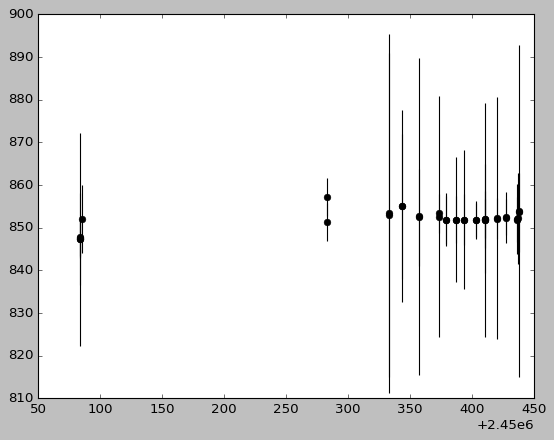

In [18]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(dark_times, dark_means, yerr=dark_stdevs, color='k',capsize=0, marker='o', ls='None')
plt.show()

In [19]:
dark_toSave = np.vstack((dark_times.T,dark_means.T,dark_stdevs.T)).T
print(np.shape(dark_toSave))

(36, 3)


In [20]:
np.savetxt("./EIT/1996_darkImgFluxes.txt",dark_toSave,fmt="%f", header="t_obs[JD] flux_mean[DN/s] flux_stdev[DN/s]")

# Load dark image fluxes from whole mission (run on wormhole)

In [54]:
dark = np.genfromtxt("./EIT/darkImgFluxes.txt")
print(np.shape(dark))
bakeoutHistory = Table.read("./EIT/EITbakeoutDates.txt", format="ascii.basic")
bakeoutHistory['jd'] = 0.
bakeoutHistory['heaterFlag'] = 0

for i in range(len(bakeoutHistory)):
    date = str(bakeoutHistory['date_beg'][i])
    time = str(bakeoutHistory['time_beg'][i])
    y = int(date[0:4])
    m = int(date[5:7])
    d = int(date[8:10])
    h = int(time[0:2])
    min = int(time[3:5])
    bakeoutHistory[i]['jd'] = astropy.time.Time({'year':y, 'month':m, 'day':d, 'hour':h, 'minute':min}).jd
    if bakeoutHistory[i]['status']=='heaterOn':
        bakeoutHistory[i]['heaterFlag'] = 1
    

print(bakeoutHistory)


(3717, 3)
  status   date_beg  time_beg dur[h]         jd         heaterFlag
--------- ---------- -------- ------ ------------------ ----------
 heaterOn 1996/05/23    19:21   45.0      2450227.30625          1
heaterOff 1996/05/25    16:37    0.0 2450229.1923611113          0
 heaterOn 1996/06/23    19:10   24.0  2450258.298611111          1
heaterOff 1996/06/24    18:48    0.0  2450259.283333333          0
 heaterOn 1996/07/23    15:48    2.5  2450288.158333333          1
heaterOff 1996/07/23    18:26    0.0 2450288.2680555554          0
 heaterOn 1996/08/05    18:50   15.0  2450301.284722222          1
heaterOff 1996/08/06    10:00    0.0 2450301.9166666665          0
 heaterOn 1996/08/09    15:05   71.5  2450305.128472222          1
heaterOff 1996/08/12    13:31    0.0 2450308.0631944444          0
 heaterOn 1996/09/06    19:49  236.0 2450333.3256944446          1
heaterOff 1996/09/16    15:43    0.0  2450343.154861111          0
 heaterOn 1996/12/19    13:14    2.5  2450437.051388

In [55]:
bakeoutFilt = np.zeros(len(dark[:,0]),dtype=int) 

for i,t in enumerate(dark[:,0]):
    if t < bakeoutHistory['jd'][0] or t > bakeoutHistory['jd'][-1]:
        continue
    else:
        prevBakeoutChangeIdx = np.arange(len(bakeoutHistory))[bakeoutHistory['jd'] <= t][-1]
        tSinceBakeout = t - bakeoutHistory['jd'][prevBakeoutChangeIdx]
        if tSinceBakeout < 5:
            bakeoutFilt[i] = 1
            

In [56]:
bakeoutFilt = bakeoutFilt.astype(bool)
print(len(dark[:,0][bakeoutFilt]))

1123


In [57]:
mmfilt = medfilt(dark[:,1], kernel_size=101)
print(np.shape(mmfilt))

(3717,)


In [58]:
mmmask = (np.abs(mmfilt - dark[:,1]) > 0.01*mmfilt)

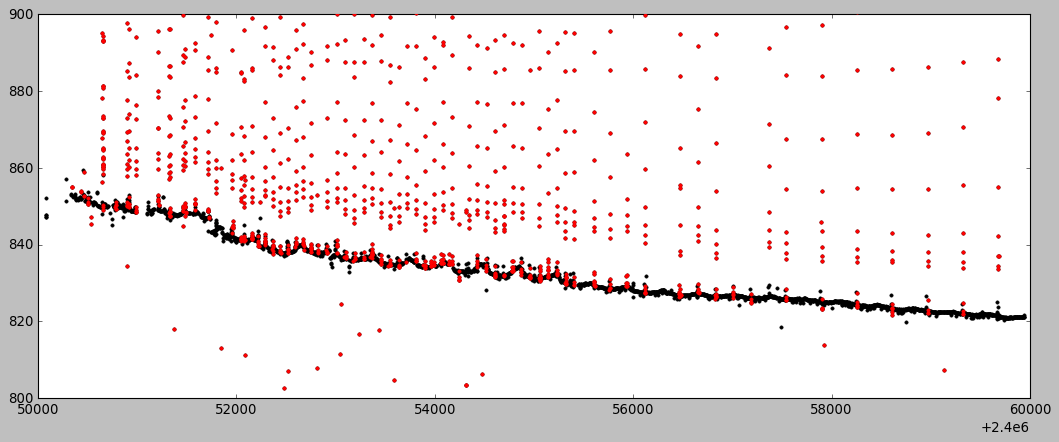

In [59]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
#ax.errorbar(dark[:,0],dark[:,1],yerr=dark[:,2],color='k',capsize=0, marker='.', ls='None',elinewidth=1,alpha=0.5,zorder=1)
ax.plot(dark[:,0],dark[:,1],'k.',zorder=2)
ax.plot(dark[:,0][bakeoutFilt | mmmask],dark[:,1][bakeoutFilt | mmmask],'r.',zorder=3)
#ax.plot(dark[:,0][mmmask],dark[:,1][mmmask],'r.')
#ax.plot(dark[:,0],mmfilt,'r.',ls='None',zorder=2)
#for i in range(len(bakeoutHistory)):
#    if bakeoutHistory['heaterFlag'][i]==1:
#        ax.axvspan(bakeoutHistory['jd'][i],bakeoutHistory['jd'][i+1],color='r',zorder=1,lw=2)
#ax.set_xlim(2459000.,2460000.)
ax.set_ylim(800,900)
plt.show()

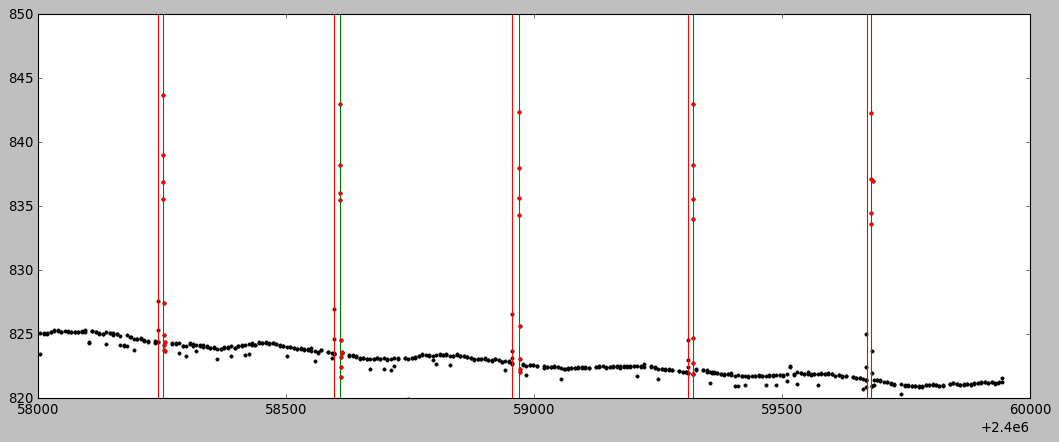

In [60]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(dark[:,0],dark[:,1],'k.',zorder=2)
ax.plot(dark[:,0][bakeoutFilt | mmmask],dark[:,1][bakeoutFilt | mmmask],'r.',zorder=3)

ax.axvline(2458242.667,color='r')
ax.axvline(2458252.583,color='g')

ax.axvline(2458597.5,color='r')
ax.axvline(2458609.5,color='g')

ax.axvline(2458955.5,color='r')
ax.axvline(2458969.5,color='g')

ax.axvline(2459311,color='r')
ax.axvline(2459320,color='g')

ax.axvline(2459670.5,color='r')
ax.axvline(2459679.5,color='g')

ax.set_xlim(2458000.,2460000.)
#ax.set_xlim(2458240.,2458255.)
#ax.set_xlim(2458590.,2458620.)
#ax.set_xlim(2458950.,2458980.)
#ax.set_xlim(2459300.,2459350.)
#ax.set_xlim(2459650.,2459700.)
ax.set_ylim(820,850)
plt.show()

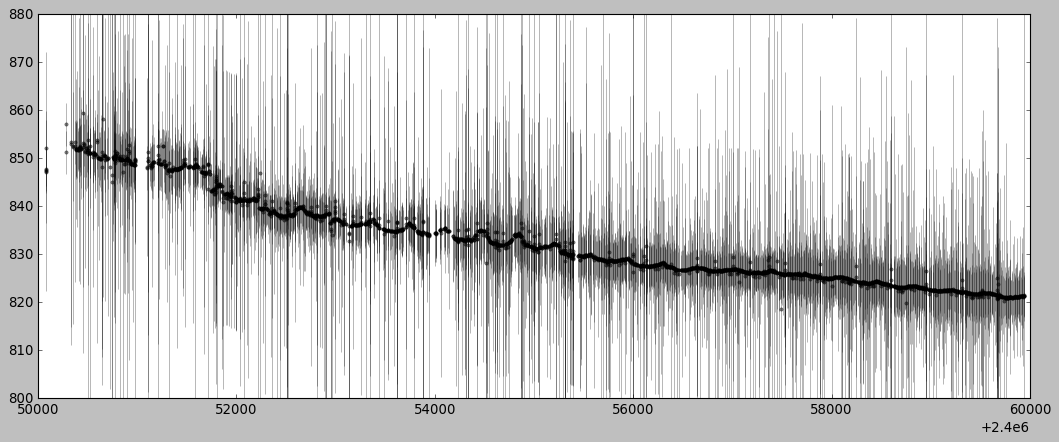

In [61]:
goodMask = ~bakeoutFilt & ~mmmask
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(dark[:,0][goodMask],dark[:,1][goodMask],yerr=dark[:,2][goodMask],color='k',capsize=0, marker='.', ls='None',elinewidth=0.5,alpha=0.5,zorder=1)
ax.set_ylim(800,880)
plt.show()

In [62]:
dark_toSave = dark[goodMask]
print(np.shape(dark_toSave))

np.savetxt("./EIT/darkImgFluxes_nobakeout.txt",dark_toSave,fmt="%f", header="t_obs[JD] flux_mean[DN/s] flux_stdev[DN/s]")


(2467, 3)
